In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import median_filter
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from matplotlib.ticker import MaxNLocator
from scipy.ndimage import gaussian_filter1d
from scipy.signal import savgol_filter
from sklearn.decomposition import PCA


from sklearn import cluster, mixture
from sklearn.neighbors import kneighbors_graph
import warnings
import time
from itertools import cycle, islice
from matplotlib.colors import ListedColormap

In [2]:
# Load data
path = r'\\NIRdata\XRAY_Dry_A\capture\\'
file_name = path + 'XRAY_Dry_A.raw'
ref_dark = path + 'DARKREF_XRAY_Dry_A.raw'
ref_white = path + 'WHITEREF_XRAY_Dry_A.raw'
samples = 384
bands = 288
frames = 619

In [3]:
data_set = np.fromfile(file_name, dtype='uint16')
data_set_reform = data_set.reshape(frames, bands, samples)
data_set_reform_transpose = data_set_reform.transpose(0, 2, 1)

dark = np.fromfile(ref_dark, dtype='uint16').reshape(25, bands, samples)
dark = dark.transpose(0, 2, 1)
white = np.fromfile(ref_white, dtype='uint16').reshape(27, bands, samples)
white = white.transpose(0, 2, 1)

wavelengths = np.loadtxt('wavelengths.txt')
wavelengths_mask = (wavelengths >= 1000) & (wavelengths <= 2500)
wavelengths_roi = wavelengths[wavelengths_mask]


In [4]:
# Apply median filter
filtered_data = median_filter(data_set_reform_transpose, size=(3, 3, 1))
filtered_dark = median_filter(dark, size=(3, 3, 1))
filtered_white = median_filter(white, size=(3, 3, 1))

# Mean centering for dark and white references
ddark = np.mean(dark, axis=0)
wwhite = np.mean(white, axis=0)

dark_mean_per_band_and_sample = np.mean(filtered_dark, axis=0)
white_mean_per_band_and_sample = np.mean(filtered_white, axis=0)


In [5]:
# Calculate reflectance intensity values
reflectance = np.divide(np.subtract(data_set_reform_transpose, ddark),
                        np.subtract(wwhite, ddark))

# Apply wavelength ROI
reflectance_roi = reflectance[:, :, wavelengths_mask]


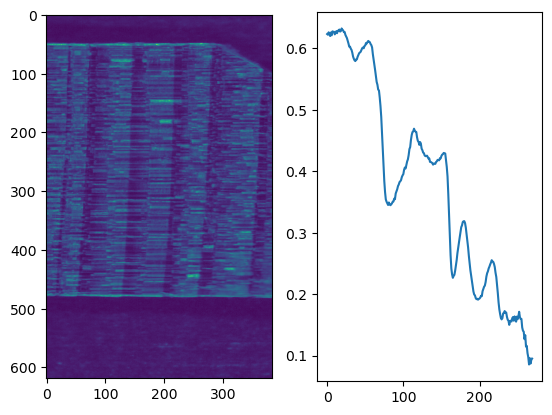

In [6]:
# Plotting the reflectance intensity values
fig, ax = plt.subplots(1, 2)
plt.rcParams['figure.figsize'] = [10, 10]
ax[0].imshow((reflectance_roi)[:, :, -1])
ax[1].plot(reflectance_roi[100, 100, :])
plt.show()



In [7]:
rreflectance_roi = reflectance_roi.reshape(-1, 270)

# Mean centering the data
mean_centered_data = rreflectance_roi - np.mean(rreflectance_roi, axis=0)

# Calculate the covariance matrix
cov_matrix = np.cov(mean_centered_data, rowvar=False)

In [8]:
# Perform eigen decomposition
eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)

# Sort eigenvalues and eigenvectors in descending order
sorted_idx = np.argsort(eigenvalues)[::-1]
eigenvalues_sorted = eigenvalues[sorted_idx]
eigenvectors_sorted = eigenvectors[:, sorted_idx]

# Compute the scores
scores = np.dot(mean_centered_data, eigenvectors_sorted[:, :2])

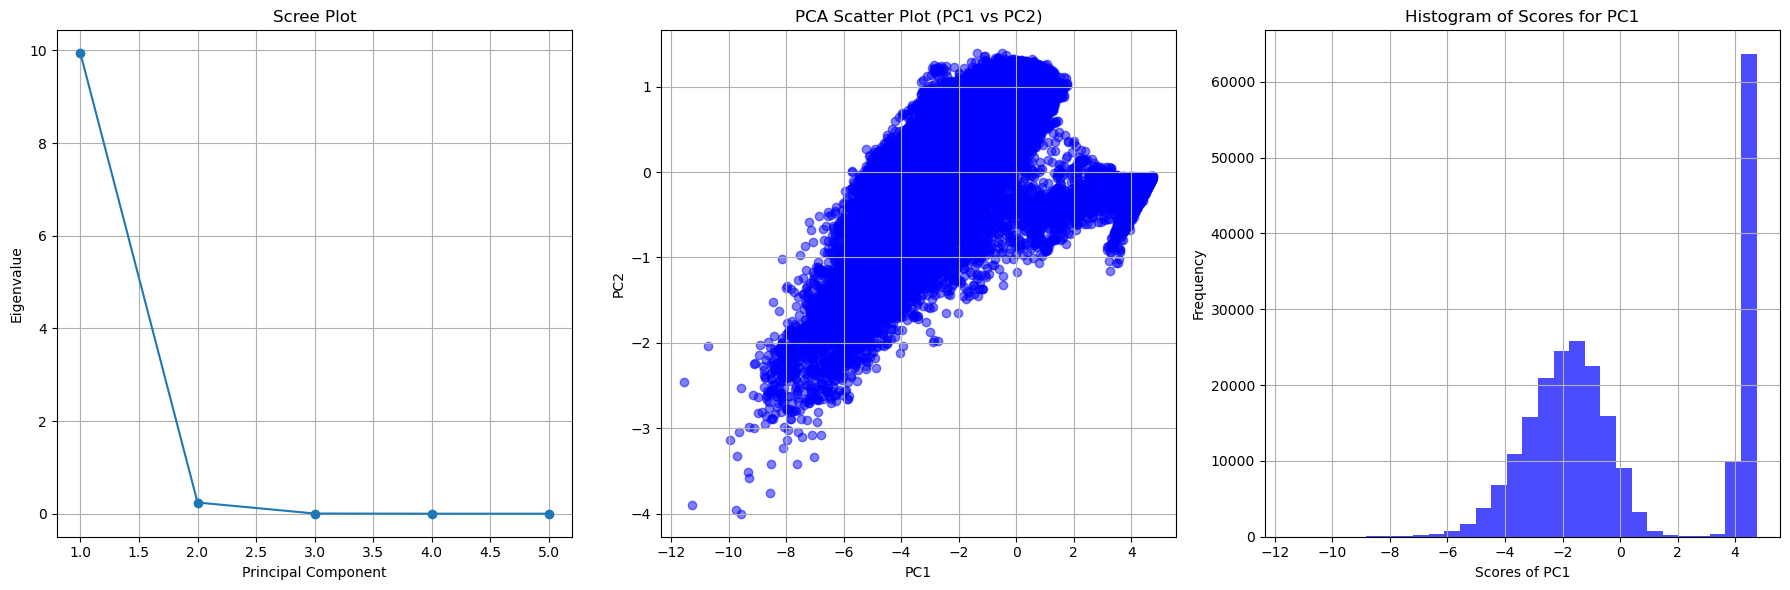

In [9]:
# Visualize the PCA results
fig, ax = plt.subplots(1, 3, figsize=(18, 6))

# Scree plot for the first few principal components
ax[0].plot(range(1, 6), eigenvalues_sorted[:5], marker='o')
ax[0].set_xlabel('Principal Component')
ax[0].set_ylabel('Eigenvalue')
ax[0].set_title('Scree Plot')
ax[0].grid(True)

# Scatter plot for the first two principal components
ax[1].scatter(scores[:, 0], scores[:, 1], c='b', marker='o', alpha=0.5)
ax[1].set_xlabel('PC1')
ax[1].set_ylabel('PC2')
ax[1].set_title('PCA Scatter Plot (PC1 vs PC2)')
ax[1].grid(True)

# Histogram of the scores for the first principal component
ax[2].hist(scores[:, 0], bins=30, color='blue', alpha=0.7)
ax[2].set_xlabel('Scores of PC1')
ax[2].set_ylabel('Frequency')
ax[2].set_title('Histogram of Scores for PC1')
ax[2].grid(True)

plt.tight_layout()
plt.show()


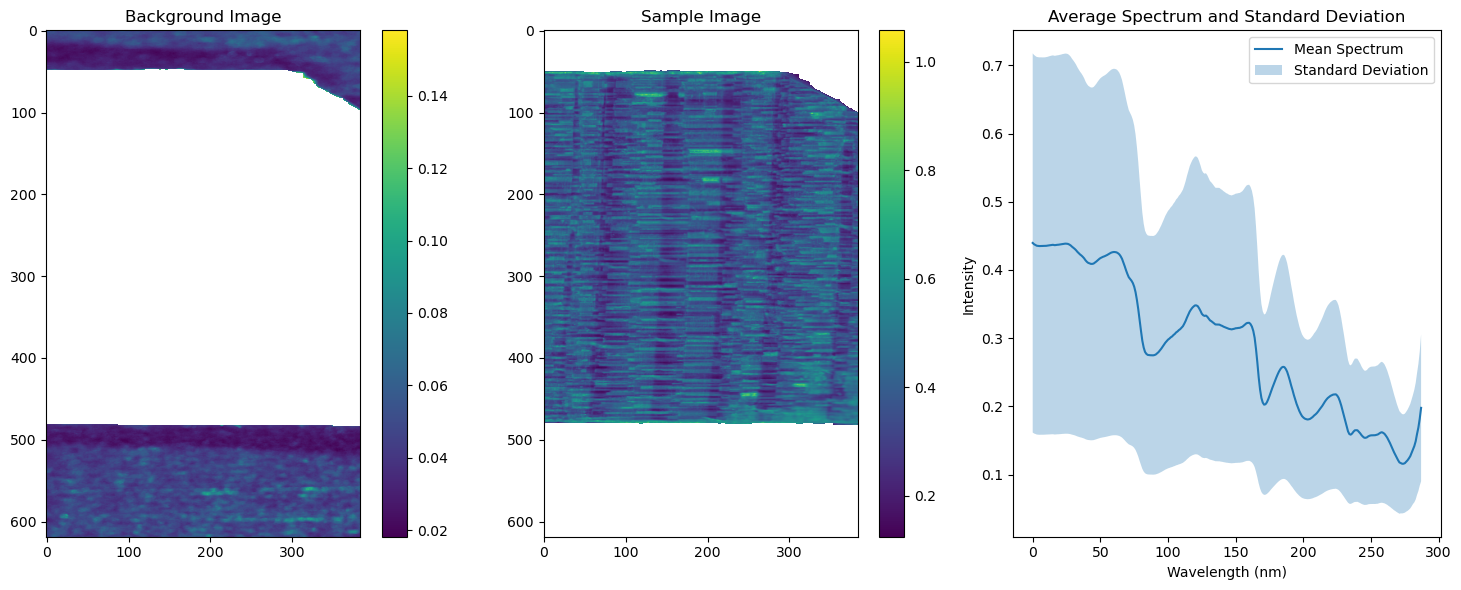

In [10]:
A = scores[:, 0].reshape(reflectance.shape[0], reflectance.shape[1])

threshold = 2.5
ind_s = A <= threshold

im_sample = np.full_like(reflectance, np.nan)
im_sample[ind_s] = reflectance[ind_s]

im_bg = np.full_like(reflectance, np.nan)
im_bg[~ind_s] = reflectance[~ind_s]

mean_spectrum = np.mean(reflectance, axis=(0, 1))
std_spectrum = np.std(reflectance, axis=(0, 1))

plt.rcParams['figure.figsize'] = [15, 6]
plt.subplot(1, 3, 1)
plt.imshow(im_bg[:, :, 90], cmap='viridis')  # This is the background image
plt.colorbar()
plt.title('Background Image')

plt.subplot(1, 3, 2)
plt.imshow(im_sample[:, :, 90], cmap='viridis')  # This is the sample image
plt.colorbar()
plt.title('Sample Image')

plt.subplot(1, 3, 3)
# Ensure wavelengths_roi matches the length of mean_spectrum
if len(wavelengths_roi) == len(mean_spectrum):
    plt.plot(wavelengths_roi, mean_spectrum, label='Mean Spectrum')
    plt.fill_between(wavelengths_roi, mean_spectrum - std_spectrum, mean_spectrum + std_spectrum, alpha=0.3, label='Standard Deviation')
else:
    plt.plot(range(len(mean_spectrum)), mean_spectrum, label='Mean Spectrum')
    plt.fill_between(range(len(mean_spectrum)), mean_spectrum - std_spectrum, mean_spectrum + std_spectrum, alpha=0.3, label='Standard Deviation')

plt.xlabel('Wavelength (nm)')
plt.ylabel('Intensity')
plt.legend()
plt.title('Average Spectrum and Standard Deviation')

plt.tight_layout()
plt.show()


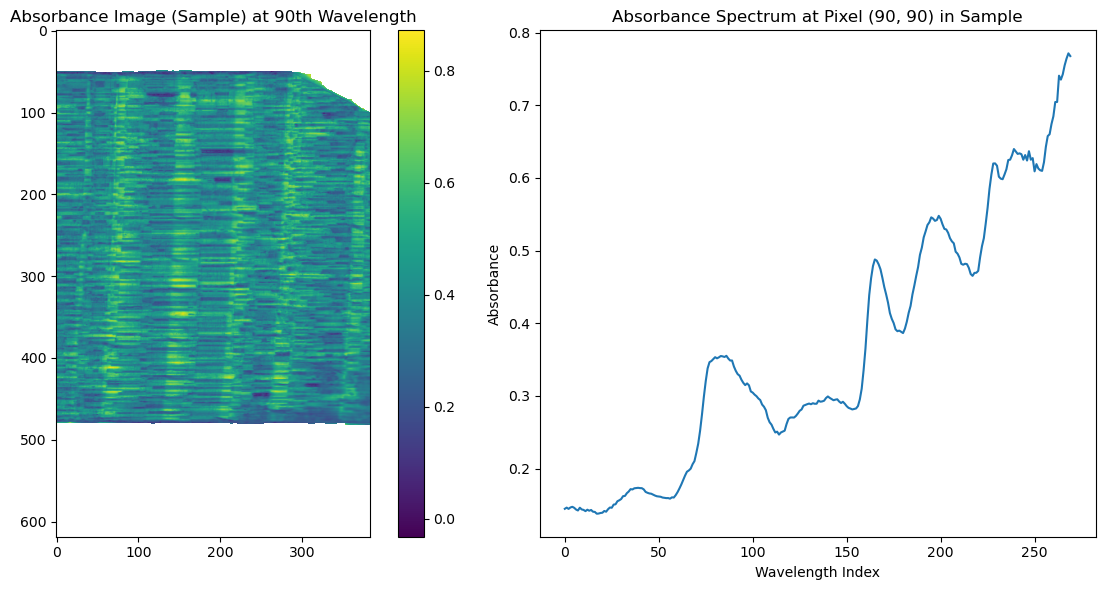

In [11]:
# Calculate absorbance for the sample image
reflectance_sample = reflectance_roi[ind_s]  # Using sample data
absorbance_sample = -np.log10(reflectance_sample)  # Calculate absorbance for the sample

absorbance_sample_image = np.full((reflectance_roi.shape[0], reflectance_roi.shape[1], reflectance_roi.shape[2]), np.nan)
absorbance_sample_image[ind_s] = absorbance_sample  # Fill the absorbance values for the sample

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Display the absorbance image for the sample at the 90th wavelength index
ax[0].imshow(absorbance_sample_image[:, :, 90], cmap='viridis')
ax[0].set_title('Absorbance Image (Sample) at 90th Wavelength')
fig.colorbar(ax[0].imshow(absorbance_sample_image[:, :, 90], cmap='viridis'), ax=ax[0])

# Check if pixel (90, 90) is part of the sample and plot the absorbance spectrum
if ind_s[90, 90]:
    ax[1].plot(absorbance_sample_image[90, 90, :])
    ax[1].set_title('Absorbance Spectrum at Pixel (90, 90) in Sample')
else:
    ax[1].set_title('Pixel (90, 90) is not part of the sample')
ax[1].set_xlabel('Wavelength Index')
ax[1].set_ylabel('Absorbance')

plt.tight_layout()
plt.show()


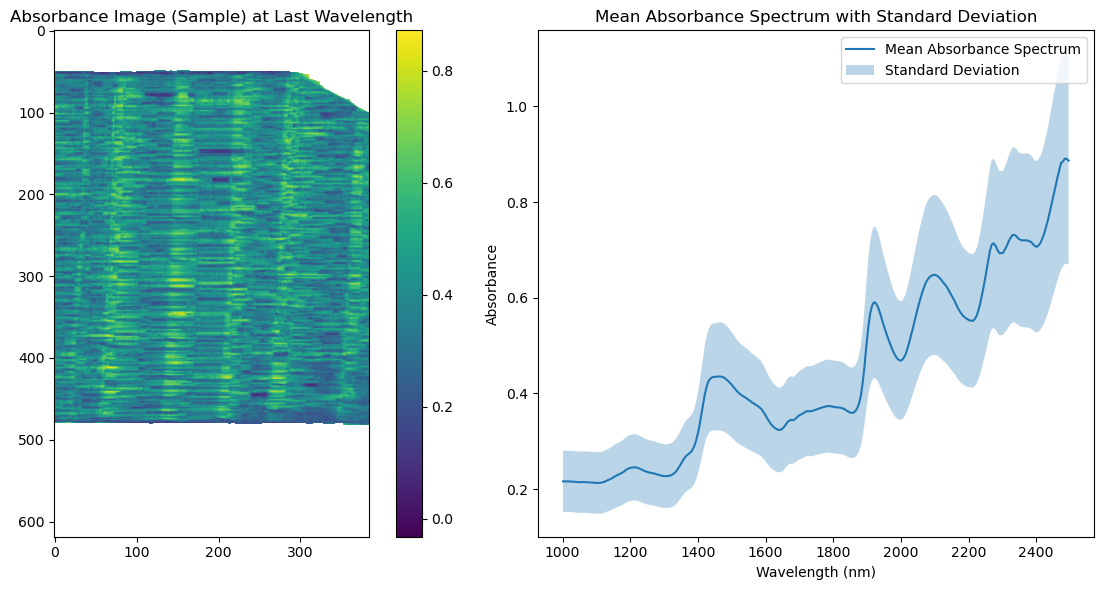

In [12]:
# Calculate absorbance for the sample image
reflectance_sample = reflectance_roi[ind_s]
reflectance_sample = np.where(reflectance_sample <= 0, 1e-10, reflectance_sample)  # Avoid log10 issues
absorbance_sample = -np.log10(reflectance_sample)

absorbance_sample_image = np.full((reflectance_roi.shape[0], reflectance_roi.shape[1], reflectance_roi.shape[2]), np.nan)
absorbance_sample_image[ind_s] = absorbance_sample

mean_absorbance_spectrum = np.nanmean(absorbance_sample_image, axis=(0, 1))
std_absorbance_spectrum = np.nanstd(absorbance_sample_image, axis=(0, 1))

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(absorbance_sample_image[:, :, 90], cmap='viridis')
ax[0].set_title('Absorbance Image (Sample) at Last Wavelength')
fig.colorbar(ax[0].imshow(absorbance_sample_image[:, :, 90], cmap='viridis'), ax=ax[0])

# Ensure wavelengths_roi matches the length of mean_absorbance_spectrum
if len(wavelengths_roi) == len(mean_absorbance_spectrum):
    ax[1].plot(wavelengths_roi, mean_absorbance_spectrum, label='Mean Absorbance Spectrum')
    ax[1].fill_between(wavelengths_roi, mean_absorbance_spectrum - std_absorbance_spectrum, mean_absorbance_spectrum + std_absorbance_spectrum, alpha=0.3, label='Standard Deviation')
else:
    ax[1].plot(range(len(mean_absorbance_spectrum)), mean_absorbance_spectrum, label='Mean Absorbance Spectrum')
    ax[1].fill_between(range(len(mean_absorbance_spectrum)), mean_absorbance_spectrum - std_absorbance_spectrum, mean_absorbance_spectrum + std_absorbance_spectrum, alpha=0.3, label='Standard Deviation')

ax[1].set_xlabel('Wavelength (nm)')
ax[1].set_ylabel('Absorbance')
ax[1].set_title('Mean Absorbance Spectrum with Standard Deviation')
ax[1].legend()

plt.tight_layout()
plt.show()

In [13]:
# Calculate absorbance for the background image
reflectance_bg = reflectance[~ind_s]
absorbance_bg = -np.log10(np.clip(reflectance_bg, 1e-10, None))  # Avoid log of zero or negative

absorbance_bg_image = np.full((reflectance.shape[0], reflectance.shape[1], reflectance.shape[2]), np.nan)
absorbance_bg_image[~ind_s] = absorbance_bg

In [14]:
def interpolate_nans(arr):
    for i in range(arr.shape[0]):
        for j in range(arr.shape[1]):
            if np.any(np.isnan(arr[i, j, :])):  # Check if there are NaNs
                valid = ~np.isnan(arr[i, j, :])
                
                # If there are no valid values (all NaNs), we fill with zeros or a default value
                if np.sum(valid) == 0:
                    arr[i, j, :] = 0  # Replace with zeros or another suitable value
                else:
                    # Perform interpolation only if there are valid data points
                    interp_func = interp1d(np.arange(arr.shape[2])[valid], arr[i, j, :][valid], 
                                           kind='linear', fill_value='extrapolate')
                    arr[i, j, :] = interp_func(np.arange(arr.shape[2]))
    return arr


In [15]:
# Apply the Savitzky-Golay filter
window_length = 15  
polyorder = 2
deriv = 2  

In [16]:
# Trim the reflectance data to the wavelength mask
reflectance_sample = reflectance[ind_s][:, wavelengths_mask]

# Compute the absorbance, still trimmed to the wavelength mask
absorbance_sample = -np.log10(np.clip(reflectance_sample, 1e-10, None))

# Create a full 3D array for the absorbance_sample_image, keeping NaN where there is no sample
absorbance_sample_image = np.full((*reflectance.shape[:2], len(wavelengths_roi)), np.nan)
absorbance_sample_image[ind_s] = absorbance_sample

# Replace NaNs with interpolation along the wavelength axis
absorbance_sample_image = interpolate_nans(absorbance_sample_image)


In [17]:
# Apply the Savitzky-Golay filter along the wavelength axis (axis=2) to the trimmed absorbance_sample_image
absorbance_sg_image = np.full_like(absorbance_sample_image, np.nan)

# Only apply the Savitzky-Golay filter to the sample pixels (where ind_s is True)
absorbance_sg_image[ind_s] = savgol_filter(absorbance_sample, window_length=window_length, polyorder=polyorder, deriv=deriv, axis=1)

# Ensure that non-sample pixels (background) remain NaN or masked properly
absorbance_sg_image[~ind_s] = np.nan  # or 0, depending on your preference

# Calculate the mean and standard deviation along the spatial dimensions (axis 0 and 1)
mean_absorbance_sg = np.nanmean(absorbance_sg_image, axis=(0, 1))
std_absorbance_sg = np.nanstd(absorbance_sg_image, axis=(0, 1))


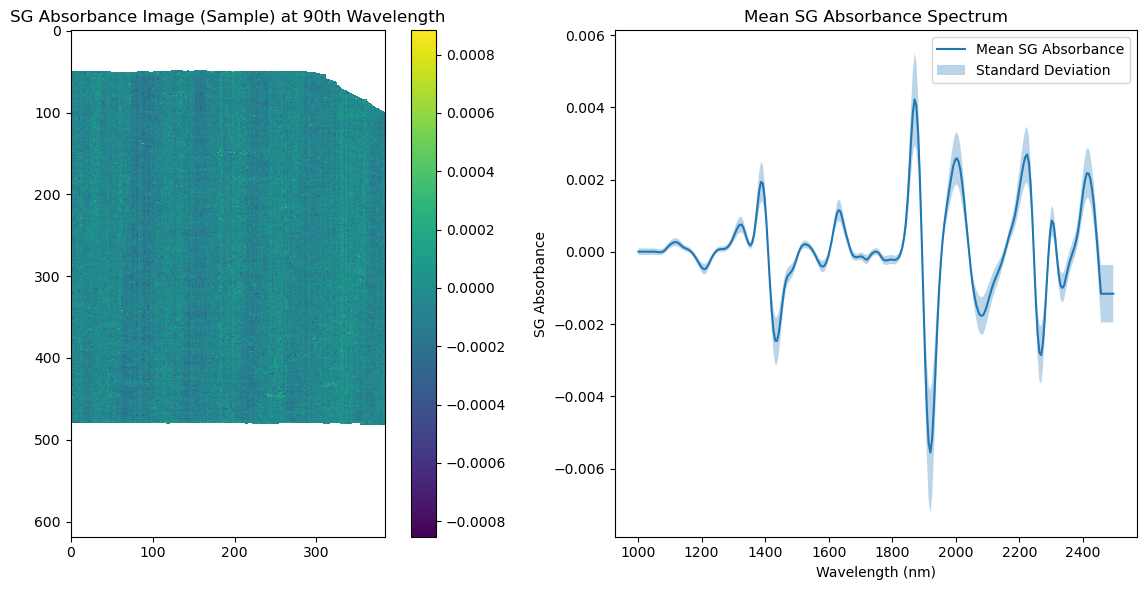

In [18]:
# Visualize the SG absorbance sample data
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Plot the SG absorbance image at a specific wavelength (e.g., the 90th wavelength)
img = ax[0].imshow(absorbance_sg_image[:, :, 90], cmap='viridis')  # Make sure NaNs are handled correctly in the colormap
ax[0].set_title('SG Absorbance Image (Sample) at 90th Wavelength')

# Add colorbar for the absorbance image
fig.colorbar(img, ax=ax[0])

# Plot the mean absorbance spectrum with standard deviation shadow
ax[1].plot(wavelengths_roi, mean_absorbance_sg, label='Mean SG Absorbance')
ax[1].fill_between(wavelengths_roi, mean_absorbance_sg - std_absorbance_sg, mean_absorbance_sg + std_absorbance_sg, alpha=0.3, label='Standard Deviation')
ax[1].set_title('Mean SG Absorbance Spectrum')
ax[1].set_xlabel('Wavelength (nm)')
ax[1].set_ylabel('SG Absorbance')
ax[1].legend()

plt.tight_layout()
plt.show()


### PCA

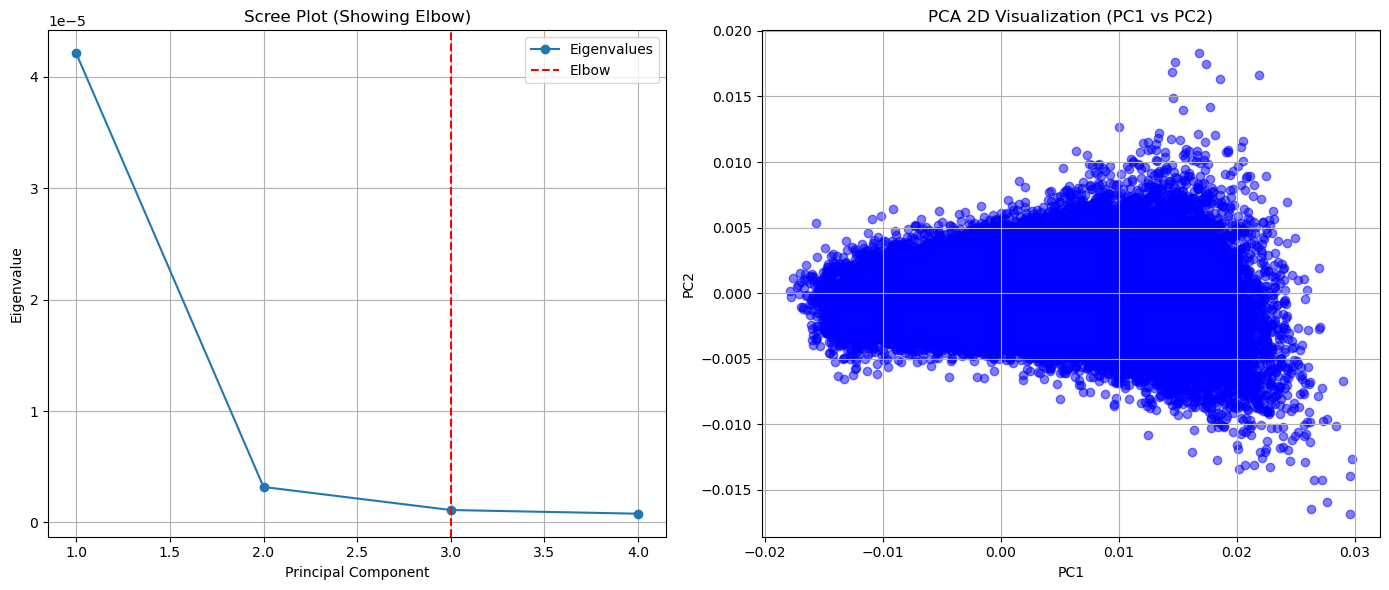

In [19]:
# Reshape the Savitzky-Golay filtered absorbance data (only sample pixels, excluding NaNs)
valid_pixels = np.where(ind_s)  # Get the indices of valid (sample) pixels
sg_data_valid = absorbance_sg_image[valid_pixels[0], valid_pixels[1], :]

# Mean center the valid data (subtract the mean spectrum)
mean_sg_data = np.nanmean(sg_data_valid, axis=0)  # Mean spectrum
mean_centered_sg_data = sg_data_valid - mean_sg_data  # Center the data by subtracting the mean

# Calculate the covariance matrix of the mean-centered data
cov_matrix_sg = np.cov(mean_centered_sg_data, rowvar=False)

# Perform eigen decomposition on the covariance matrix
eigenvalues_sg, eigenvectors_sg = np.linalg.eigh(cov_matrix_sg)

# Sort the eigenvalues and eigenvectors in descending order
sorted_idx_sg = np.argsort(eigenvalues_sg)[::-1]
eigenvalues_sorted_sg = eigenvalues_sg[sorted_idx_sg]
eigenvectors_sorted_sg = eigenvectors_sg[:, sorted_idx_sg]

# Project the data onto the first 4 principal components (scores)
scores_sg = np.dot(mean_centered_sg_data, eigenvectors_sorted_sg[:, :4])

# Plot the results

# Scree Plot (Eigenvalues)
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Scree plot (explained variance - eigenvalues)
ax[0].plot(range(1, 5), eigenvalues_sorted_sg[:4], marker='o', label='Eigenvalues')
ax[0].set_xlabel('Principal Component')
ax[0].set_ylabel('Eigenvalue')
ax[0].set_title('Scree Plot (Showing Elbow)')
ax[0].grid(True)

# Highlight the elbow (example: after PC2)
elbow_index = 2  # Elbow index is where the decrease in variance becomes smaller
ax[0].axvline(x=elbow_index + 1, linestyle='--', color='r', label='Elbow')
ax[0].legend()

# 2D Visualization: PC1 vs PC2
ax[1].scatter(scores_sg[:, 0], scores_sg[:, 1], c='blue', alpha=0.5, label='Samples')
ax[1].set_xlabel('PC1')
ax[1].set_ylabel('PC2')
ax[1].set_title('PCA 2D Visualization (PC1 vs PC2)')
ax[1].grid(True)

plt.tight_layout()
plt.show()


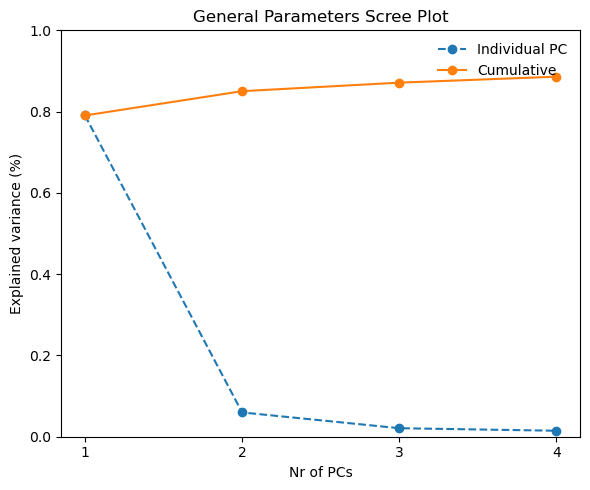

In [20]:
# Compute explained variance ratios for the first 4 components
explained_variance_ratio_sg = eigenvalues_sorted_sg / np.sum(eigenvalues_sorted_sg)
explained_4 = explained_variance_ratio_sg[:4]
cumulative_4 = np.cumsum(explained_4)

# Plot scree plot (first 4 PCs only)
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(6, 5))
plt.plot(range(1, 5), explained_4, 'o--',  label='Individual PC')
plt.plot(range(1, 5), cumulative_4, 'o-',  label='Cumulative')
plt.title("General Parameters Scree Plot")
plt.ylim((0, 1))
plt.xticks(np.arange(1, 5))
plt.xlabel('Nr of PCs')
plt.ylabel('Explained variance (%)')
plt.legend(loc='upper right', frameon=False)
plt.grid(False)
plt.tight_layout()
plt.show()


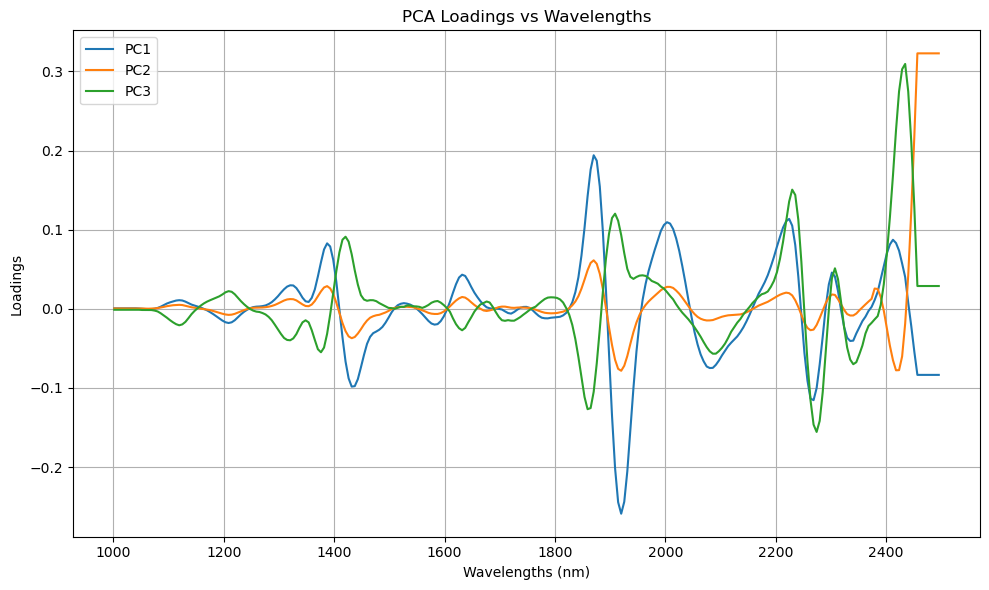

In [21]:
fig, ax = plt.subplots(figsize=(10, 6))

# Plot loadings for the first four principal components (PC1 to PC4)
ax.plot(wavelengths_roi, eigenvectors_sorted_sg[:, 0], label='PC1')
ax.plot(wavelengths_roi, eigenvectors_sorted_sg[:, 1], label='PC2')
ax.plot(wavelengths_roi, eigenvectors_sorted_sg[:, 2], label='PC3')
#ax.plot(wavelengths_roi, eigenvectors_sorted_sg[:, 3], label='PC4')
# Customize the plot
ax.set_xlabel('Wavelengths (nm)')
ax.set_ylabel('Loadings')
ax.set_title('PCA Loadings vs Wavelengths')
ax.grid(True)
ax.legend()

plt.tight_layout()
plt.show()

### Clustering

In [22]:
# Define the number of clusters/components
n_clusters = 3

# K-Means Clustering
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans_labels = kmeans.fit_predict(scores_sg)

# Gaussian Mixture Model Clustering
gmm = GaussianMixture(n_components=n_clusters, random_state=42)
gmm_labels = gmm.fit_predict(scores_sg)

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


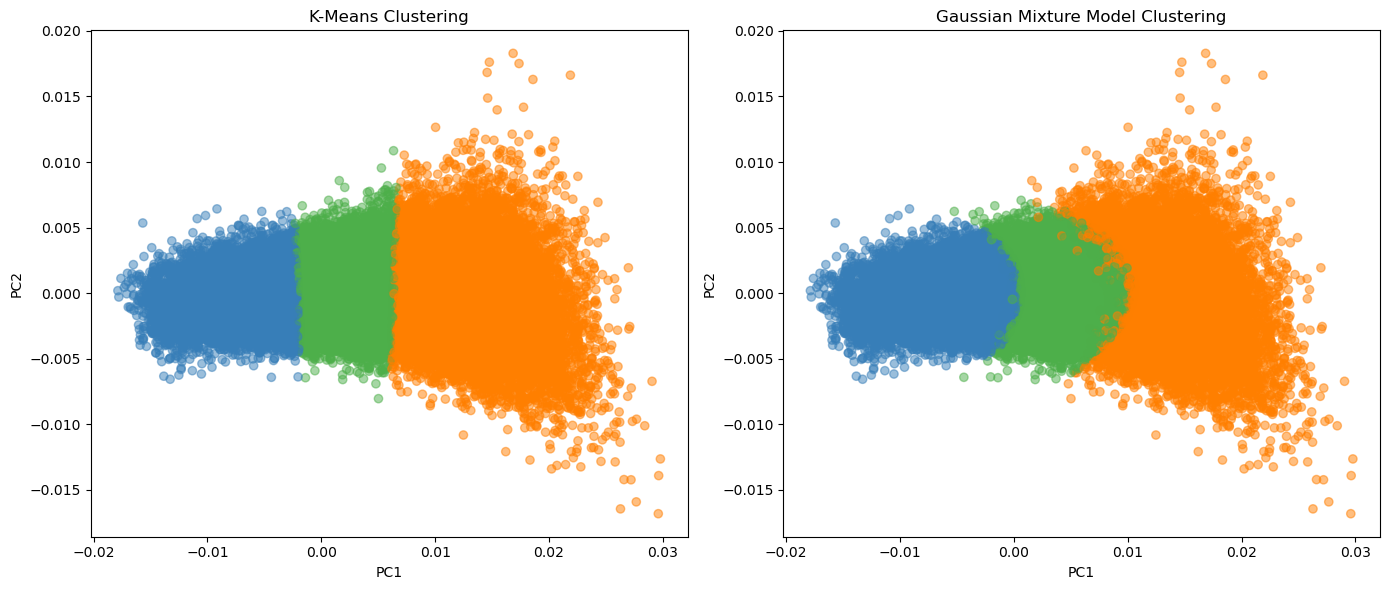

C:\Users\noriege1\AppData\Local\Temp\ipykernel_22936\3441135311.py:44: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap1_with_nan = plt.cm.get_cmap(cmap1)  # Copy the existing colormap
C:\Users\noriege1\AppData\Local\Temp\ipykernel_22936\3441135311.py:48: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap2_with_nan = plt.cm.get_cmap(cmap2)  # Copy the existing colormap


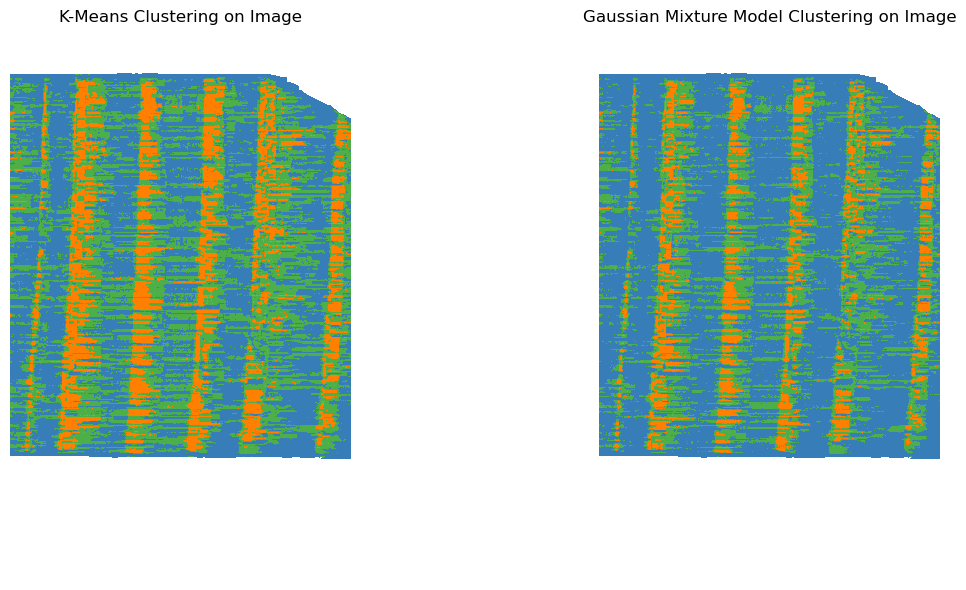

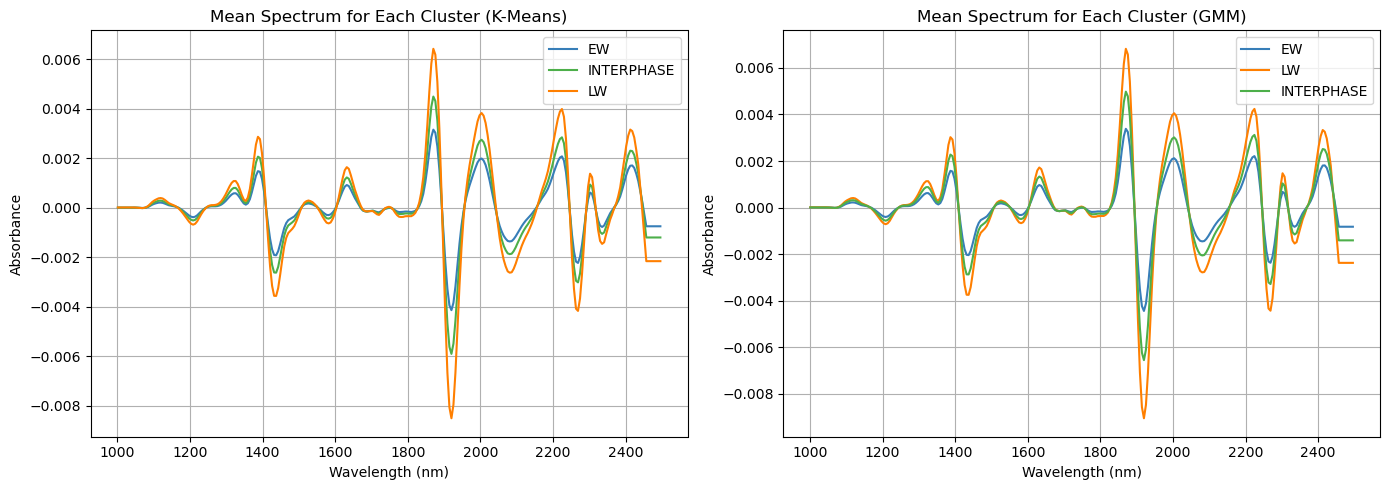

In [23]:
# Define custom colors for K-Means and GMM clusters
colors1 = ["#377eb8", "#f781bf", "#4daf4a", "#ff7f00"]  # ["blue", "pink", "green", "orange"]
cmap1 = ListedColormap(colors1)

colors2 = ["#377eb8", "#f781bf", "#ff7f00", "#4daf4a"]  # ["blue", "pink", "orange", "green"]
cmap2 = ListedColormap(colors2)


# === STEP 1: Scatter Plot Clustering ===
# Plot clustering results in 2D
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# K-Means clustering visualization
scatter = ax[0].scatter(scores_sg[:, 0], scores_sg[:, 1], c=kmeans_labels, cmap=cmap1, alpha=0.5)
ax[0].set_xlabel('PC1')
ax[0].set_ylabel('PC2')
ax[0].set_title('K-Means Clustering')
#fig.colorbar(scatter, ax=ax[0], label='Cluster')

# Gaussian Mixture Model clustering visualization
scatter = ax[1].scatter(scores_sg[:, 0], scores_sg[:, 1], c=gmm_labels, cmap=cmap2, alpha=0.5)
ax[1].set_xlabel('PC1')
ax[1].set_ylabel('PC2')
ax[1].set_title('Gaussian Mixture Model Clustering')
#fig.colorbar(scatter, ax=ax[1], label='Cluster')

plt.tight_layout()
plt.show()

# === STEP 2: Clustering Results on Image ===

image_height, image_width = absorbance_sg_image.shape[:2]

# Initialize the label images with NaN instead of -1 for invalid pixels
kmeans_labels_image = np.full((image_height, image_width), np.nan)  # Use NaN for invalid pixels
gmm_labels_image = np.full((image_height, image_width), np.nan)

# Assign cluster labels to valid image pixels
kmeans_labels_image[valid_pixels[0], valid_pixels[1]] = kmeans_labels
gmm_labels_image[valid_pixels[0], valid_pixels[1]] = gmm_labels

# Create a custom colormap that handles NaN values
# Use a colormap that has a specific color for NaN, like white or transparent for background
cmap1_with_nan = plt.cm.get_cmap(cmap1)  # Copy the existing colormap
cmap1_with_nan.set_bad(color='white')   # Set the color for NaN values (e.g., white for background)
# Create a custom colormap that handles NaN values
# Use a colormap that has a specific color for NaN, like white or transparent for background
cmap2_with_nan = plt.cm.get_cmap(cmap2)  # Copy the existing colormap
cmap2_with_nan.set_bad(color='white')   # Set the color for NaN values (e.g., white for background)

# Plot clustering results on the image
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# K-Means clustering on image
im1 = ax[0].imshow(kmeans_labels_image, cmap=cmap1_with_nan, interpolation='none')
ax[0].set_title('K-Means Clustering on Image')
ax[0].axis('off')

# Gaussian Mixture Model clustering on image
im2 = ax[1].imshow(gmm_labels_image, cmap=cmap2_with_nan, interpolation='none')
ax[1].set_title('Gaussian Mixture Model Clustering on Image')
ax[1].axis('off')

plt.tight_layout()
plt.show()


# === STEP 3: Spectral Data with Clustering ===
colors3 = ["#377eb8", "#4daf4a", "#ff7f00"]  # ["blue", "green", "orange"]
colors4 = ["#377eb8", "#ff7f00", "#4daf4a"]  # ["blue", "orange", "green"] - switched 2 and 3

# Mean spectra for each cluster (K-Means and GMM)
unique_clusters_kmeans = np.unique(kmeans_labels)
unique_clusters_gmm = np.unique(gmm_labels)

labels_kmeans = ["EW", "INTERPHASE", "LW"]
labels_gmm = ["EW", "LW", "INTERPHASE"]

# Prepare the figure
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Plot for K-Means clustering
for cluster in unique_clusters_kmeans:
    cluster_spectra_kmeans = absorbance_sg_image[valid_pixels[0], valid_pixels[1], :][kmeans_labels == cluster]
    mean_spectrum_kmeans = np.nanmean(cluster_spectra_kmeans, axis=0)
    ax[0].plot(wavelengths_roi, mean_spectrum_kmeans, label=labels_kmeans[cluster], color=colors3[cluster])
    
ax[0].set_title('Mean Spectrum for Each Cluster (K-Means)')
ax[0].set_xlabel('Wavelength (nm)')
ax[0].set_ylabel('Absorbance')
ax[0].legend()
ax[0].grid(True)

# Plot for GMM clustering with switched Cluster 2 and 3 colors
for cluster in unique_clusters_gmm:
    cluster_spectra_gmm = absorbance_sg_image[valid_pixels[0], valid_pixels[1], :][gmm_labels == cluster]
    mean_spectrum_gmm = np.nanmean(cluster_spectra_gmm, axis=0)
    ax[1].plot(wavelengths_roi, mean_spectrum_gmm, label=labels_gmm[cluster], color=colors4[cluster])
    
ax[1].set_title('Mean Spectrum for Each Cluster (GMM)')
ax[1].set_xlabel('Wavelength (nm)')
ax[1].set_ylabel('Absorbance')
ax[1].legend()
ax[1].grid(True)

# Save the figure
plt.tight_layout()
plt.savefig('mean_spectra_clusters.png', format='png', dpi=300)

# Show the plot
plt.show()

#### Band identification

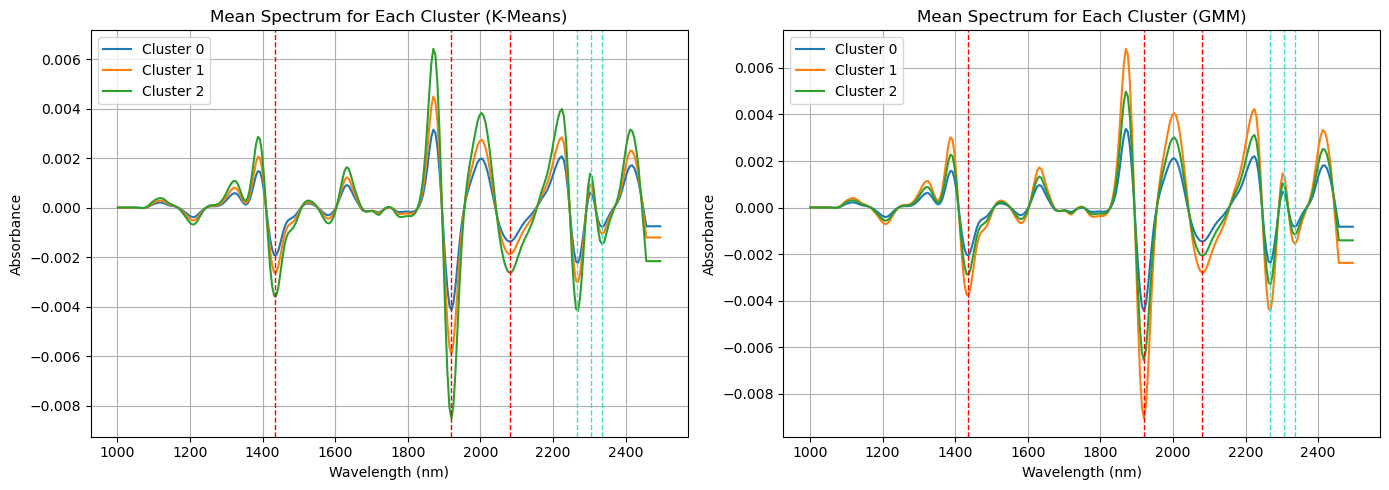

In [24]:
# Mean spectra for each cluster (K-Means and GMM)
unique_clusters_kmeans = np.unique(kmeans_labels)
unique_clusters_gmm = np.unique(gmm_labels)

# Prepare the figure
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Wavelengths for vertical lines
red_lines = [1435, 1920, 2080]  # Red dotted lines
turquoise_lines = [2267, 2305, 2335]  # Turquoise dotted lines

# Plot for K-Means clustering
for cluster in unique_clusters_kmeans:
    cluster_spectra_kmeans = absorbance_sg_image[valid_pixels[0], valid_pixels[1], :][kmeans_labels == cluster]
    mean_spectrum_kmeans = np.nanmean(cluster_spectra_kmeans, axis=0)
    ax[0].plot(wavelengths_roi, mean_spectrum_kmeans, label=f'Cluster {cluster}')  # Use wavelengths_roi instead of index

# Add vertical dotted lines (Red)
for line in red_lines:
    ax[0].axvline(x=line, color='red', linestyle='--', linewidth=1)

# Add vertical dotted lines (Turquoise)
for line in turquoise_lines:
    ax[0].axvline(x=line, color='turquoise', linestyle='--', linewidth=1)

ax[0].set_title('Mean Spectrum for Each Cluster (K-Means)')
ax[0].set_xlabel('Wavelength (nm)')  # Change label to Wavelength (nm)
ax[0].set_ylabel('Absorbance')
ax[0].legend()
ax[0].grid(True)

# Plot for GMM clustering
for cluster in unique_clusters_gmm:
    cluster_spectra_gmm = absorbance_sg_image[valid_pixels[0], valid_pixels[1], :][gmm_labels == cluster]
    mean_spectrum_gmm = np.nanmean(cluster_spectra_gmm, axis=0)
    ax[1].plot(wavelengths_roi, mean_spectrum_gmm, label=f'Cluster {cluster}')  # Use wavelengths_roi instead of index

# Add vertical dotted lines (Red)
for line in red_lines:
    ax[1].axvline(x=line, color='red', linestyle='--', linewidth=1)

# Add vertical dotted lines (Turquoise)
for line in turquoise_lines:
    ax[1].axvline(x=line, color='turquoise', linestyle='--', linewidth=1)

ax[1].set_title('Mean Spectrum for Each Cluster (GMM)')
ax[1].set_xlabel('Wavelength (nm)')  # Change label to Wavelength (nm)
ax[1].set_ylabel('Absorbance')
ax[1].legend()
ax[1].grid(True)

# Save the figure
plt.tight_layout()
plt.savefig('mean_spectra_clusters.png', format='png', dpi=300)  # Save with new filename

# Show the plot
plt.show()
